In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import decimal

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import pandas_datareader as pdr
from decimal import Decimal
import decimal
import requests_cache


In [3]:
tbill_data = pdr.get_data_fred('DGS3MO', '2020-01-01')

In [10]:
tbill_monthly = tbill_data.resample('ME').last().ffill()
tbill_monthly_return = (1 + tbill_monthly / 100) ** (1/12) - 1

,DGS3MO
DATE,
2020-01-31,0.001283
2020-02-29,0.001052
2020-03-31,0.000092
2020-04-30,0.000075
2020-05-31,0.000117
...,...
2025-02-28,0.003531
2025-03-31,0.003531
2025-04-30,0.003523


In [34]:
import requests_cache
import datetime

expire_after = datetime.timedelta(days=1)
session = requests_cache.CachedSession(cache_name='fred_cache', backend='sqlite', expire_after=expire_after)


tbill_data = pdr.get_data_fred('DGS3MO', '1982-01-01', session=session)
tbill_monthly = tbill_data.resample('ME').last().ffill()
tbill_monthly_return = (1 + tbill_monthly / 100) ** (1/12) - 1
# (1 + tbill_monthly_return).rolling(12).apply(lambda x: x.prod()) - 1


In [57]:
tbill_monthly_return

,DGS3MO
DATE,
1982-01-31,0.010296
1982-02-28,0.010237
1982-03-31,0.010971
1982-04-30,0.010349
1982-05-31,0.009466
...,...
2025-02-28,0.003531
2025-03-31,0.003531
2025-04-30,0.003523


In [56]:
(1 + tbill_monthly_return).rolling(12).apply(lambda x: x.prod()) - 1

,DGS3MO
DATE,
1982-01-31,NaN
1982-02-28,NaN
1982-03-31,NaN
1982-04-30,NaN
1982-05-31,NaN
...,...
2025-02-28,0.049514
2025-03-31,0.048564
2025-04-30,0.047606


In [4]:
from datetime import timedelta

all_assets = ['AGG']
prices = yf.download(tickers=all_assets, start='2020-01-01', end='2025-06-01', auto_adjust=True)['Close']
monthly_prices = prices.resample('ME').last()
monthly_returns = monthly_prices.pct_change()

pdr_expire_after = timedelta(days=1)
pdr_session = requests_cache.CachedSession(cache_name='fred_cache', backend='sqlite', expire_after=pdr_expire_after)

t_bills = pdr.data.DataReader('TB3MS', 'fred', start='1982-01-01', session=pdr_session)
t_bills = t_bills.rename(columns={'TB3MS': 'TBillRate'}) / 100
t_bills = t_bills.reindex(monthly_returns.index, method='ffill')

t_bills

[*********************100%***********************]  1 of 1 completed


,TBillRate
Date,
2020-01-31,0.0152
2020-02-29,0.0152
2020-03-31,0.0029
2020-04-30,0.0014
2020-05-31,0.0013
...,...
2025-01-31,0.0421
2025-02-28,0.0422
2025-03-31,0.0420


In [9]:
avgs = t_bills['TBillRate'].rolling(window=12).sum() / 12
avgs

Date
2020-01-31         NaN
2020-02-29         NaN
2020-03-31         NaN
2020-04-30         NaN
2020-05-31         NaN
                ...   
2025-01-31    0.048825
2025-02-28    0.047975
2025-03-31    0.047108
2025-04-30    0.046250
2025-05-31    0.045417
Freq: ME, Name: TBillRate, Length: 65, dtype: float64

In [22]:
from db.schemas import JobBase
from dual_momentum import dual_momentum

# def dual_momentum(job: JobBase):
#     tickers = [t.strip() for t in job.tickers.split(",") if t.strip()]
#
#     start = datetime.strptime(f'{job.start_year}-{job.start_month:02}-01', '%Y-%m-%d') - relativedelta(months=job.lookback_period)
#     start = start.strftime('%Y-%m-%d')
#     end = f'{job.end_year}-{job.end_month:02}-01'
#
#     if job.lookback_period < job.rebalance_period:
#         raise RuntimeError('Lookback period cannot be less than rebalancing period')
#
#     all_assets = tickers + [job.safe_asset]
#     prices = yf.download(tickers=all_assets, start=start, end=end, auto_adjust=True)['Close']
#     monthly_prices = prices.resample('ME').last()
#     monthly_returns = monthly_prices.pct_change().fillna(0)
#
#     pdr_expire_after = timedelta(days=1)
#     pdr_session = requests_cache.CachedSession(cache_name='fred_cache', backend='sqlite', expire_after=pdr_expire_after)
#
#     t_bills = pdr.data.DataReader('TB3MS', 'fred', start='1934-01-01', session=pdr_session)
#     t_bills = t_bills.rename(columns={'TB3MS': 'TBillRate'}) / 100
#     t_bills = t_bills.reindex(monthly_returns.index, method='ffill')
#
#     portfolio = pd.DataFrame(index=monthly_prices.index, columns=['Selected Asset', 'DM Return', 'Switching Cost', 'DM Balance'])
#     selected_asset = tickers[0]
#     trades = pd.DataFrame(columns=['Trade Date', 'Sold', 'Bought'])
#     trades.loc[len(trades)] = [monthly_prices.index[0], selected_asset, job.safe_asset]
#
#     balance = job.initial_investment
#     for i in range(job.lookback_period, len(monthly_prices)):
#         date = monthly_prices.index[i]
#         month_start = date.replace(day=1)
#
#         switched = False
#         if (i - job.lookback_period) % job.rebalance_period == 0:
#             momentums = (monthly_prices.iloc[i] / monthly_prices.iloc[i - job.lookback_period]) - 1
#             # Relative momentum
#             best_asset = momentums.idxmax()
#
#             # Absolute momentum
#             if momentums[best_asset] > t_bills.iloc[i]['TBillRate']:
#                 if selected_asset != best_asset:
#                     trades.loc[len(trades)] = [month_start, selected_asset, best_asset]
#                     switched = True
#                 selected_asset = best_asset
#             else:
#                 if selected_asset != job.safe_asset:
#                     trades.loc[len(trades)] = [month_start, selected_asset, job.safe_asset]
#                     switched = True
#                 selected_asset = job.safe_asset
#
#         if pd.notna(monthly_prices.at[date, selected_asset]):
#             asset_return = monthly_prices.at[date, selected_asset] / monthly_prices.iloc[i - 1][selected_asset] - 1
#         else:
#             asset_return = 0
#
#         sc = 0 if not switched else job.switching_cost / 100
#         balance = round(balance * (1 - sc) * (1 + asset_return), 4)
#         portfolio.iloc[i] = [selected_asset, asset_return, sc, balance]
#
#     # Cut portfolio to real start date.
#     portfolio = portfolio[job.lookback_period:]
#
#     for ticker in all_assets:
#         portfolio[f'{ticker} Return'] = monthly_returns[ticker]
#         portfolio[f'{ticker} Balance'] = job.initial_investment * (1 + portfolio[f'{ticker} Return']).cumprod()
#
#     portfolio[f'Treasuries Return'] = t_bills['TBillRate']
#
#     return portfolio, trades


job = JobBase(
    start_year=2007,
    start_month=7,
    end_year=2025,
    end_month=1,
    tickers='SPY,VEU',
    safe_asset='AGG',
    initial_investment=10_000,
    rebalance_period=1,
    lookback_period=12,
    switching_cost=1,
)

portfolio, trades = dual_momentum(job)

# portfolio, trades = dual_momentum(
#     start_year=2015,
#     start_month=6,
#     end_year=2025,
#     end_month=1,
#     tickers=['SPY', 'VEU'],
#     safe_asset='AGG',
#     initial_investment=10_000,
#     rebalance_period=1,
#     lookback_period=12,
#     switching_cost=Decimal(1),
# )

portfolio

[*********************100%***********************]  3 of 3 completed


,Selected Asset,DM Return,Switching Cost,DM Balance,SPY Return,SPY Balance,VEU Return,VEU Balance,AGG Return,AGG Balance,Treasury Bills Return
Date,,,,,,,,,,,
2007-07-31,SPY,-0.03131,0,9686.89763,-0.031310,9686.897630,-0.011578,9884.218592,0.010732,10107.321395,0.0482
2007-08-31,SPY,0.012833,0,9811.207624,0.012833,9811.207624,-0.001953,9864.918553,0.012794,10236.635766,0.0420
2007-09-30,SPY,0.038714,0,10191.043519,0.038714,10191.043519,0.061533,10471.935219,0.006328,10301.418156,0.0389
2007-10-31,SPY,0.013567,0,10329.301515,0.013567,10329.301515,0.063662,11138.600409,0.010080,10405.253657,0.0390
2007-11-30,SPY,-0.038733,0,9929.21598,-0.038733,9929.215980,-0.049614,10585.967111,0.018036,10592.920411,0.0327
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,SPY,0.023366,0,82070.618886,0.023366,51909.247910,0.025777,17490.736978,0.014615,16870.671621,0.0505
2024-09-30,SPY,0.021005,0,83794.483795,0.021005,52999.583673,0.025482,17936.440533,0.010174,17042.322160,0.0472
2024-10-31,SPY,-0.008923,0,83046.744551,-0.008923,52526.642415,-0.045397,17122.182643,-0.025187,16613.072260,0.0451


In [29]:
for col in portfolio.columns:
    if col.endswith('Balance'):
        portfolio[col] = portfolio[col].round(3)
    elif col.endswith('Return') or col == 'Switching Cost':
        portfolio[col] = portfolio[col].round(2).astype(str) + '%'
portfolio

,Selected Asset,DM Return,Switching Cost,DM Balance,SPY Return,SPY Balance,VEU Return,VEU Balance,AGG Return,AGG Balance,Treasury Bills Return
Date,,,,,,,,,,,
2007-07-31,SPY,-0.03%,0.0,9686.898,-0.03%,9686.898,-0.01%,9884.219,0.01%,10107.321,0.05%
2007-08-31,SPY,0.01%,0.0,9811.208,0.01%,9811.208,-0.0%,9864.919,0.01%,10236.636,0.04%
2007-09-30,SPY,0.04%,0.0,10191.044,0.04%,10191.044,0.06%,10471.935,0.01%,10301.418,0.04%
2007-10-31,SPY,0.01%,0.0,10329.302,0.01%,10329.302,0.06%,11138.600,0.01%,10405.254,0.04%
2007-11-30,SPY,-0.04%,0.0,9929.216,-0.04%,9929.216,-0.05%,10585.967,0.02%,10592.920,0.03%
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,SPY,0.02%,0.0,82070.619,0.02%,51909.248,0.03%,17490.737,0.01%,16870.672,0.05%
2024-09-30,SPY,0.02%,0.0,83794.484,0.02%,52999.584,0.03%,17936.441,0.01%,17042.322,0.05%
2024-10-31,SPY,-0.01%,0.0,83046.745,-0.01%,52526.642,-0.05%,17122.183,-0.03%,16613.072,0.05%


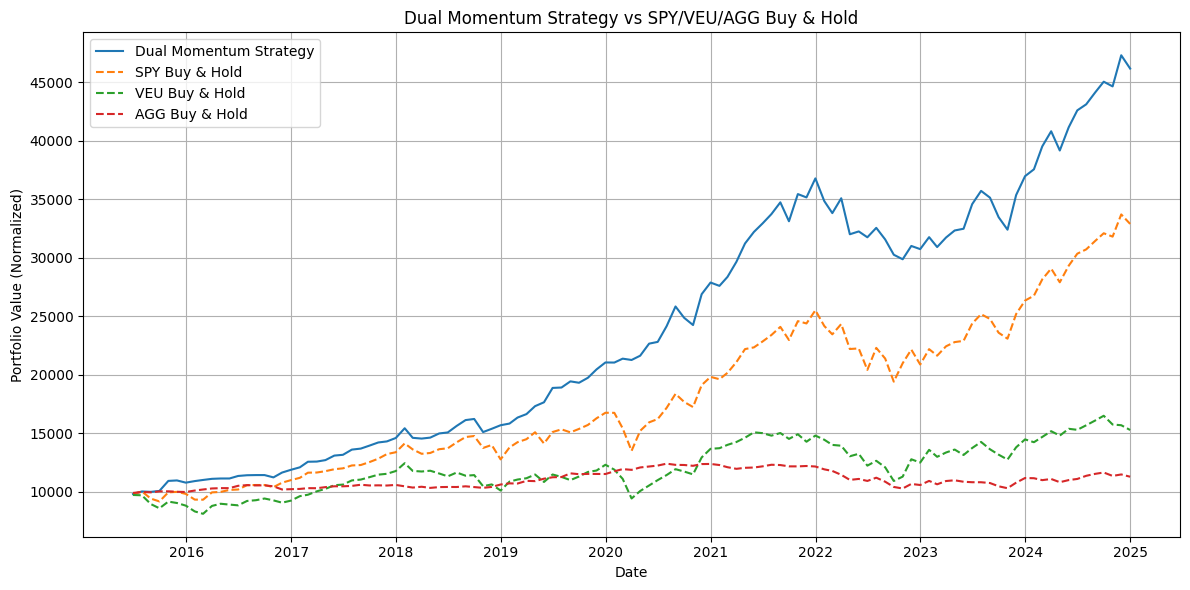

In [160]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(portfolio.index, portfolio['DM Balance'], label='Dual Momentum Strategy')
plt.plot(portfolio.index, portfolio['SPY Balance'], label='SPY Buy & Hold', linestyle='--')
plt.plot(portfolio.index, portfolio['VEU Balance'], label='VEU Buy & Hold', linestyle='--')
plt.plot(portfolio.index, portfolio['AGG Balance'], label='AGG Buy & Hold', linestyle='--')
plt.title('Dual Momentum Strategy vs SPY/VEU/AGG Buy & Hold')
plt.ylabel('Portfolio Value (Normalized)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [161]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2020, 1, 1)
end = datetime.datetime.today()

# 13-week T-Bill (3-month) secondary market rate
t_bill = web.DataReader('TB3MS', 'fred', start, end)
print(t_bill.tail())

            TB3MS
DATE             
2025-01-01   4.21
2025-02-01   4.22
2025-03-01    4.2
2025-04-01   4.21
2025-05-01   4.25


In [162]:
t_bill

,TB3MS
DATE,
2020-01-01,1.52
2020-02-01,1.52
2020-03-01,0.29
2020-04-01,0.14
2020-05-01,0.13
...,...
2025-01-01,4.21
2025-02-01,4.22
2025-03-01,4.2


[*********************100%***********************]  3 of 3 completed

will start 12 10
DONE



/var/folders/h3/gxgq2spd6fl74mjrlfg4pspw0000gn/T/ipykernel_64417/3380247005.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio['Balance'] = initial_investment * (1 + portfolio['Return'].fillna(0)).cumprod()


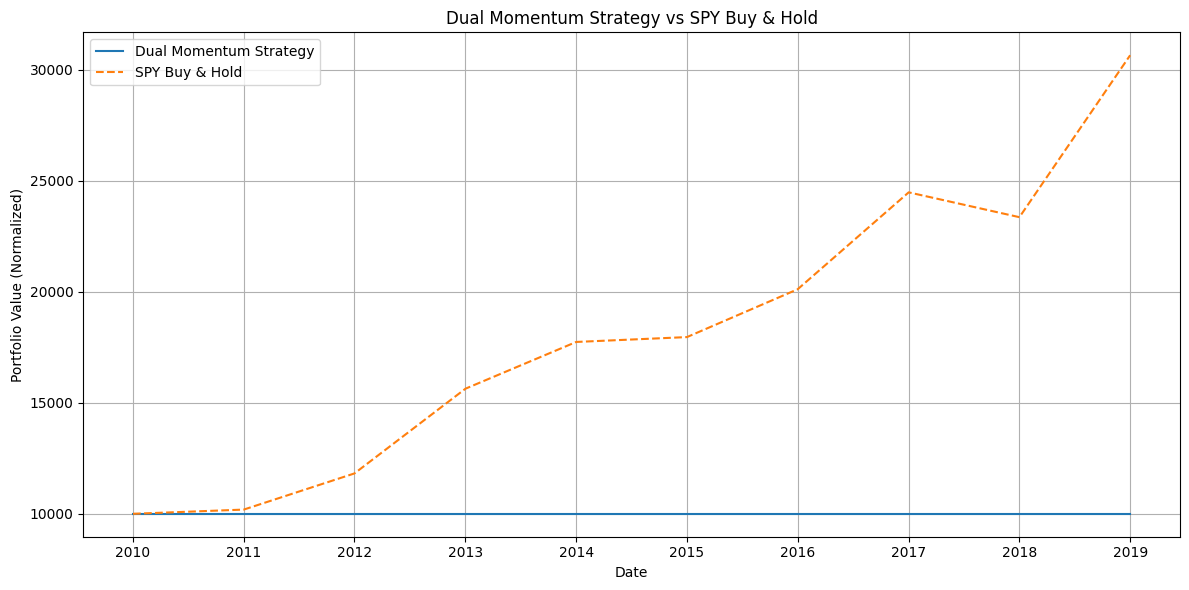

In [99]:
portfolio = dual_momentum(
    time_period=TimePeriod.YEAR_TO_YEAR,
    start_year=2010,
    end_year=2020,
    initial_investment=10_000,
    tickers=['SPY', 'VEU'],
    out_of_market_asset='AGG',
    lookback_period=12,
)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(portfolio.index, portfolio['Balance'], label='Dual Momentum Strategy')
plt.plot(portfolio.index, portfolio['SPY Buy & Hold'], label='SPY Buy & Hold', linestyle='--')
plt.title('Dual Momentum Strategy vs SPY Buy & Hold')
plt.ylabel('Portfolio Value (Normalized)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
portfolio

,Selected Asset,Return,Balance,SPY Buy & Hold
Date,,,,
2010-01-01,None,0,10000,10000.0
2011-01-01,NaN,NaN,10000,10189.500186378804
2012-01-01,NaN,NaN,10000,11818.831468981825
2013-01-01,NaN,NaN,10000,15637.232706024452
2014-01-01,NaN,NaN,10000,17742.604779206966
2015-01-01,NaN,NaN,10000,17961.598497207386
2016-01-01,NaN,NaN,10000,20116.61235433972
2017-01-01,NaN,NaN,10000,24482.997936663607
2018-01-01,NaN,NaN,10000,23364.374452431188


In [ ]:
## INITIAL VERSION

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Strategy parameters
lookback_months = 12
assets = ['SPY', 'EFA']  # Risk assets: US and International equities
safety_asset = 'AGG'  # Bond ETF as fallback
all_assets = assets + [safety_asset]

# Load data
start = '2008-01-01'
end = '2024-01-01'
data = yf.download(all_assets, start=start, end=end)['Adj Close']
monthly_prices = data.resample('M').last()

# Initialize portfolio
portfolio = pd.DataFrame(index=monthly_prices.index, columns=['Selected Asset', 'Return'])
portfolio.iloc[0] = [None, 0]

# Dual Momentum Logic with Monthly Rebalancing
for i in range(lookback_months, len(monthly_prices)):
    current_date = monthly_prices.index[i]
    past_date = monthly_prices.index[i - lookback_months]

    # Calculate cumulative returns for each risk asset
    cumulative_returns = (monthly_prices.loc[current_date, assets] /
                          monthly_prices.loc[past_date, assets]) - 1

    # Relative Momentum: choose the best performing risk asset
    best_asset = cumulative_returns.idxmax()

    # Absolute Momentum: check if its return is positive
    if cumulative_returns[best_asset] > 0:
        selected = best_asset
    else:
        selected = safety_asset

    # Record selection and return
    this_month_return = (monthly_prices.iloc[i][selected] /
                         monthly_prices.iloc[i - 1][selected]) - 1

    portfolio.iloc[i] = [selected, this_month_return]

# Calculate portfolio value over time
portfolio['Portfolio Value'] = (1 + portfolio['Return'].fillna(0)).cumprod()

# Combine with SPY for comparison
spy_returns = monthly_prices['SPY'].pct_change().fillna(0)
spy_value = (1 + spy_returns).cumprod()
portfolio['SPY Buy & Hold'] = spy_value

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Dual Momentum Strategy')
plt.plot(portfolio.index, portfolio['SPY Buy & Hold'], label='SPY Buy & Hold', linestyle='--')
plt.title('Dual Momentum Strategy vs SPY Buy & Hold')
plt.ylabel('Portfolio Value (Normalized)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
prices = yf.download(tickers=['SPY', 'VEU', 'AGG'], start='1980-01-01', end='2025-06-01', auto_adjust=True, interval='1mo')
# prices['Close'].pct_change()
prices

[*********************100%***********************]  3 of 3 completed


Price           Close                              High              \
Ticker            AGG         SPY        VEU        AGG         SPY   
Date                                                                  
1993-01-01        NaN   24.452511        NaN        NaN   24.469902   
1993-02-01        NaN   24.713390        NaN        NaN   25.113396   
1993-03-01        NaN   25.148180        NaN        NaN   25.513403   
1993-04-01        NaN   24.620409        NaN        NaN   25.301882   
1993-05-01        NaN   25.284430        NaN        NaN   25.529061   
...               ...         ...        ...        ...         ...   
2025-01-01  95.833405  600.015015  59.188503  96.158099  608.948164   
2025-02-01  97.653641  592.397949  60.414745  97.692998  611.390803   
2025-03-01  97.651772  557.712280  60.474564  98.125621  595.548472   
2025-04-01  98.050819  554.539978  62.340000  99.565851  567.419983   
2025-05-01  97.460030  589.390015  65.230003  98.225011  595.539978   

Price                        Low                              Open  \
Ticker            VEU        AGG         SPY        VEU        AGG   
Date                                                                 
1993-01-01        NaN        NaN   24.348162        NaN        NaN   
1993-02-01        NaN        NaN   23.826421        NaN        NaN   
1993-03-01        NaN        NaN   24.609042        NaN        NaN   
1993-04-01        NaN        NaN   24.201041        NaN        NaN   
1993-05-01        NaN        NaN   24.515587        NaN        NaN   
...               ...        ...         ...        ...        ...   
2025-01-01  60.025936  94.200101  573.624372  55.908564  95.508711   
2025-02-01  61.840374  95.056104  580.693169  58.091870  95.774358   
2025-03-01  63.016768  96.753442  545.229811  59.856460  97.395110   
2025-04-01  62.500000  95.208915  481.799988  53.650002  97.842876   
2025-05-01  65.790001  96.029429  556.039978  62.099998  98.185271   

Price                                   Volume                          
Ticker             SPY        VEU          AGG         SPY         VEU  
Date                                                                    
1993-01-01   24.469902        NaN          NaN     1003200         NaN  
1993-02-01   24.469909        NaN          NaN     5417600         NaN  
1993-03-01   24.800349        NaN          NaN     3019200         NaN  
1993-04-01   25.301882        NaN          NaN     2697200         NaN  
1993-05-01   24.655377        NaN          NaN     1808000         NaN  
...                ...        ...          ...         ...         ...  
2025-01-01  587.622302  57.264403  153162900.0   995606200  56118400.0  
2025-02-01  590.892468  58.191563  162617500.0   871641300  55910600.0  
2025-03-01  594.391917  61.302028  173294600.0  1496591400  53277000.0  
2025-04-01  557.450012  60.689999  211039700.0  2236888000  91829800.0  
2025-05-01  560.369995  62.459999  174232800.0  1402172600  51754800.0  

[389 rows x 15 columns]